In [1]:
"""

Java/HDFS logs

t1 INFO added user abc
t2 ERROR deleted user xyz

Elastic search

t1 | INFO | added user abc
t2 | ERROR | deleted user xyz

ML 

Events

event_id | event
e1 | added user <>
e2 | deleted user <>


Logs

0-5 mins - tw1
t1 | INFO | added user 1
t2 | ERROR | deleted user 2
t3 | INFO | added user 3
t4 | ERROR | deleted user 4
t5 | INFO | added user 5


6-10 mins
t6 | ERROR | deleted user 6
t7 | INFO | added user 7
t8 | ERROR | deleted user 8

11-15 mins
t9 | INFO | added user 9
t10 | ERROR | deleted user 0


Log_summary


time_window_id | count_info | count_error | count_e1 | count_e2
tw1 | 3 | 2 | 3 | 2
tw2 | 1 | 2 | 1 | 2
tw3 | 1 | 1 | 1 | 1

"""

'\n\nJava/HDFS logs\n\nt1 INFO added user abc\nt2 ERROR deleted user xyz\n\nElastic search\n\nt1 | INFO | added user abc\nt2 | ERROR | deleted user xyz\n\nML \n\nEvents\n\nevent_id | event\ne1 | added user <>\ne2 | deleted user <>\n\n\nLogs\n\n0-5 mins - tw1\nt1 | INFO | added user 1\nt2 | ERROR | deleted user 2\nt3 | INFO | added user 3\nt4 | ERROR | deleted user 4\nt5 | INFO | added user 5\n\n\n6-10 mins\nt6 | ERROR | deleted user 6\nt7 | INFO | added user 7\nt8 | ERROR | deleted user 8\n\n11-15 mins\nt9 | INFO | added user 9\nt10 | ERROR | deleted user 0\n\n\nLog_summary\n\n\ntime_window_id | count_info | count_error | count_e1 | count_e2\ntw1 | 3 | 2 | 3 | 2\ntw2 | 1 | 2 | 1 | 2\ntw3 | 1 | 1 | 1 | 1\n\n'

In [ ]:
# To do - Read data from elastic based on start time and end time and write to log file

In [26]:
import pandas as pd
import os
import numpy as np
import re
from sklearn.utils import shuffle
from collections import OrderedDict
import sys
sys.path.append('../')
from log_parser import Drain

log_file_path = 'data/unstructured/Java/'
#label_file_name = 'data/unstructured/HDFS/anomaly_label.csv'
unstructured_log_filename = 'app.log'
structured_log_file_path = 'data/structured/Java/'
structured_log_filename = 'app.log_structured.csv'


def parseLog(log_file_path, log_file_name, structured_log_file_path, log_type):
    if log_type == 'HDFS':
        log_format = '<Date> <Time> <Pid> <Level> <Component>: <Content>'
        
    if log_type == 'Java':
        log_format = '<Date> <Time> <Pid> <Level> <Component>- <Content>'

    # Regular expression list for optional preprocessing (default: [])
    regex      = [
        r'blk_(|-)[0-9]+' , # block id
        r'(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)', # IP
        r'(?<=[^A-Za-z0-9])(\-?\+?\d+)(?=[^A-Za-z0-9])|[0-9]+$', # Numbers
    ]
    st         = 0.5  # Similarity threshold
    depth      = 4  # Depth of all leaf nodes

    parser = Drain.LogParser(log_format, indir=log_file_path, outdir=structured_log_file_path,  depth=depth, st=st, rex=regex)
    parser.parse(log_file_name)

## parse the logs - convert unstructured to structured log
parseLog(log_file_path, unstructured_log_filename, structured_log_file_path, 'Java')
    

## read structured log 
print("Loading", structured_log_file_path+structured_log_filename)
structured_log = pd.read_csv(structured_log_file_path+structured_log_filename, engine='c', na_filter=False, memory_map=True)

structured_log

Parsing file: data/unstructured/Java/app.log
Processed 100.0% of log lines.
Parsing done. [Time taken: 0:00:00.493898]
Loading data/structured/Java/app.log_structured.csv


,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate,ParameterList
0,1,29-03-2023,01:22:14.295,[main],INFO,com.bank.management.ElkApplication.logStarting,Starting ElkApplication v0.0.1-SNAPSHOT using ...,b2c05d68,Starting ElkApplication v0.<*>.<*>-SNAPSHOT us...,"['0.1', '11', '0.18', '172', '31-3-241', '1480..."
1,2,29-03-2023,01:22:14.454,[main],INFO,com.bank.management.ElkApplication.logStartupP...,"No active profile set, falling back to default...",0d0355b4,"No active profile set, falling back to default...",[]
2,3,29-03-2023,01:22:35.563,[main],INFO,o.s.b.w.e.tomcat.TomcatWebServer.initialize,Tomcat initialized with port(s): 8080 (http)\,3535c482,Tomcat initialized with port(s): <*> (http)\,['8080']
3,4,29-03-2023,01:22:35.746,[main],INFO,o.a.coyote.http11.Http11NioProtocol.log,"Initializing ProtocolHandler [""http-nio-8080""]\",a0c3ac0e,"Initializing ProtocolHandler [""http-nio-<*>""]\",['8080']
4,5,29-03-2023,01:22:35.748,[main],INFO,o.a.catalina.core.StandardService.log,Starting service [Tomcat]\,cadfeb81,Starting service [Tomcat]\,[]
...,...,...,...,...,...,...,...,...,...,...
658,659,29-03-2023,03:18:16.096,[http-nio-8080-exec-3],INFO,c.b.management.services.UserService.getUserById,User found: com.bank.management.domain.User@47...,4ca50db4,User found: <*>,['com.bank.management.domain.User@47c6d55d\\']
659,660,29-03-2023,03:18:18.515,[http-nio-8080-exec-2],INFO,c.b.management.services.UserService.getUserById,Fetching user details for user id...\,d4260df9,Fetching <*> details for <*> id...\,"['user', 'user']"
660,661,29-03-2023,03:18:18.516,[http-nio-8080-exec-2],INFO,c.b.management.services.UserService.getUserById,User found: com.bank.management.domain.User@56...,4ca50db4,User found: <*>,['com.bank.management.domain.User@56e5abfc\\']
661,662,29-03-2023,03:18:21.174,[http-nio-8080-exec-5],INFO,c.b.management.services.UserService.getUserById,Fetching user details for user id...\,d4260df9,Fetching <*> details for <*> id...\,"['user', 'user']"


In [27]:
def fill_zeros(x):
    if len(str(x)) < 6:
        return str(x).zfill(6)
    else:
        return str(x)
    
structured_log['Date'] = structured_log['Date'].apply(fill_zeros)
structured_log['Time'] = structured_log['Time'].apply(fill_zeros)

structured_log.loc[:,'Date'] = pd.to_datetime(structured_log.Date.astype(str)+' '+structured_log.Time.astype(str), format="%d-%m-%Y %H:%M:%S.%f")
# structured_log.set_index("Date", inplace=True)

structured_log = structured_log.drop(columns=['Time'])

structured_log.head()

structured_log['EventTemplate'].nunique()

23

In [4]:
# TODO: Cleaning: Remove rows and colums with count 0 (no data present)


In [28]:
# Adding relevant columns to the dataframe
LOG_LEVELS = ['WARN', 'INFO', 'DEBUG', 'TRACE', 'ERROR', 'FATAL']
df_grouped = structured_log.groupby(pd.Grouper(key='Date', freq='5Min',closed='right',label='right')).agg(
    total_msgs=pd.NamedAgg(column="Content", aggfunc="count"),    
).reset_index()

for level in LOG_LEVELS:
    df_grouped[level + '_count'] = 0

for event_id in structured_log['EventId'].unique():
    df_grouped[event_id + '_count'] = 0

df_grouped.head()

,Date,total_msgs,WARN_count,INFO_count,DEBUG_count,TRACE_count,ERROR_count,FATAL_count,b2c05d68_count,0d0355b4_count,...,e84b414a_count,deec0f0e_count,d4260df9_count,e9469db0_count,4ca50db4_count,a97f8d99_count,c4a0945f_count,a1404f2b_count,3f7fe44b_count,7e78fdb9_count
0,2023-03-29 01:25:00,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023-03-29 01:30:00,62,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2023-03-29 01:35:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023-03-29 01:40:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023-03-29 01:45:00,24,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Populating all the log level counts
df_grouped_logLevel = structured_log.groupby([pd.Grouper(key='Date', freq='5Min',closed='right',label='right'), 'Level']).agg(
    count=pd.NamedAgg(column="Level", aggfunc="count"),    
).reset_index()

for row in df_grouped_logLevel.itertuples():
    df_grouped.loc[df_grouped['Date'] == row.Date, row.Level + '_count'] = row.count

df_grouped.head()

,Date,total_msgs,WARN_count,INFO_count,DEBUG_count,TRACE_count,ERROR_count,FATAL_count,b2c05d68_count,0d0355b4_count,...,e84b414a_count,deec0f0e_count,d4260df9_count,e9469db0_count,4ca50db4_count,a97f8d99_count,c4a0945f_count,a1404f2b_count,3f7fe44b_count,7e78fdb9_count
0,2023-03-29 01:25:00,26,0,26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023-03-29 01:30:00,62,0,62,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2023-03-29 01:35:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023-03-29 01:40:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023-03-29 01:45:00,24,0,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Populating all the event id counts
df_grouped_eventId = structured_log.groupby([pd.Grouper(key='Date', freq='5Min',closed='right',label='right'), 'EventId']).agg(
    count=pd.NamedAgg(column="EventId", aggfunc="count"),    
).reset_index()

for row in df_grouped_eventId.itertuples():
    df_grouped.loc[df_grouped['Date'] == row.Date, row.EventId + '_count'] = row.count

df_grouped

,Date,total_msgs,WARN_count,INFO_count,DEBUG_count,TRACE_count,ERROR_count,FATAL_count,b2c05d68_count,0d0355b4_count,...,e84b414a_count,deec0f0e_count,d4260df9_count,e9469db0_count,4ca50db4_count,a97f8d99_count,c4a0945f_count,a1404f2b_count,3f7fe44b_count,7e78fdb9_count
0,2023-03-29 01:25:00,26,0,26,0,0,0,0,1,1,...,3,3,3,3,0,0,0,0,0,0
1,2023-03-29 01:30:00,62,0,62,0,0,0,0,0,0,...,24,20,5,2,3,3,3,1,1,0
2,2023-03-29 01:35:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023-03-29 01:40:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023-03-29 01:45:00,24,0,24,0,0,0,0,0,0,...,11,11,0,0,0,0,0,1,1,0
5,2023-03-29 01:50:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2023-03-29 01:55:00,404,0,404,0,0,0,0,0,0,...,202,202,0,0,0,0,0,0,0,0
7,2023-03-29 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2023-03-29 02:05:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2023-03-29 02:10:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Filtering only the feature columns

feature_cols = list(df_grouped.columns);
feature_cols.remove('Date')

data_with_feature_columns = df_grouped[feature_cols]

In [32]:
#Scaling the values of the input data

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

data_scaled = min_max_scaler.fit_transform(data_with_feature_columns)
data_scaled = pd.DataFrame(data_scaled, columns=feature_cols)

data_scaled

,total_msgs,WARN_count,INFO_count,DEBUG_count,TRACE_count,ERROR_count,FATAL_count,b2c05d68_count,0d0355b4_count,3535c482_count,...,e84b414a_count,deec0f0e_count,d4260df9_count,e9469db0_count,4ca50db4_count,a97f8d99_count,c4a0945f_count,a1404f2b_count,3f7fe44b_count,7e78fdb9_count
0,0.064356,0.0,0.064356,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.014851,0.014851,0.6,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.153465,0.0,0.153465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.118812,0.099010,1.0,0.666667,1.0,1.000000,1.000000,1.0,1.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.059406,0.0,0.059406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.054455,0.054455,0.0,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.0
5,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
6,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
7,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
8,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
9,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


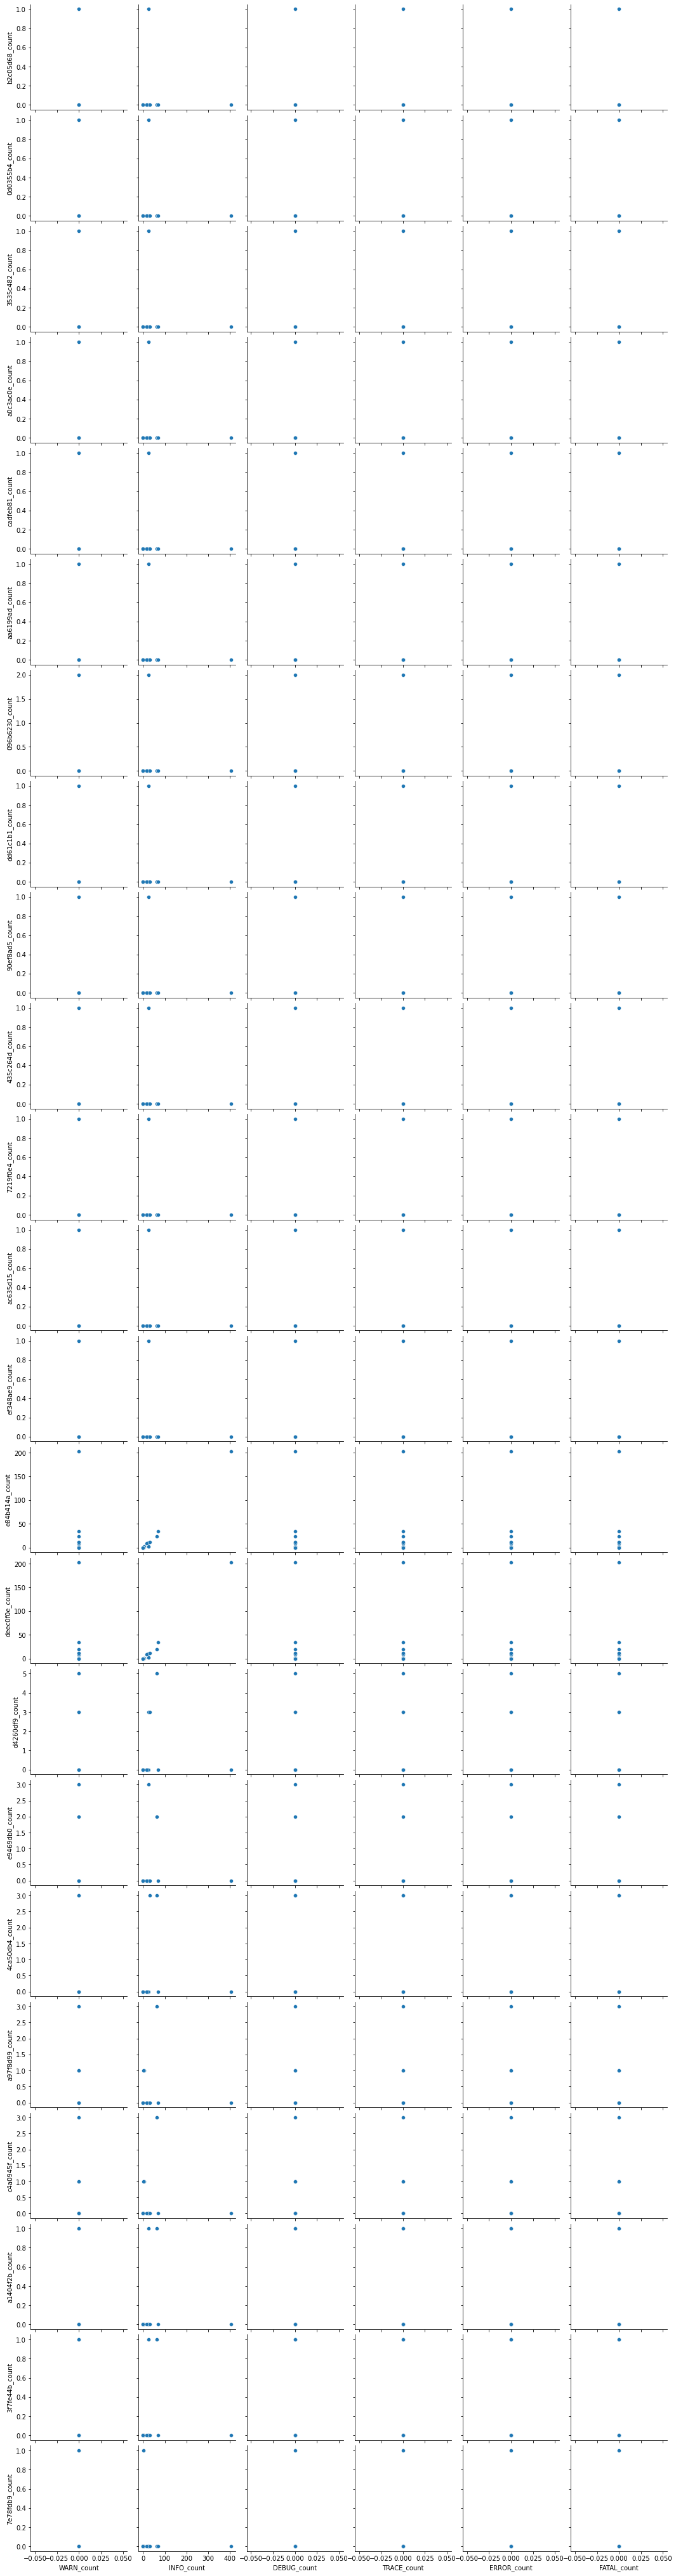

In [33]:
# Visualizing the relationship between log_levels and the event_ids

import seaborn as sns

all_columns = list(df_grouped.columns)
log_level_columns = all_columns[2:8]
event_id_columns = all_columns[8:]

sns.pairplot(df_grouped, y_vars= event_id_columns,
                  x_vars= log_level_columns)

In [34]:
# Applying Kmeans clustering to different values of k (1-15)

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
RANDOM_STATE = 123

cluster_check_range = range(1, 15)

kmeans = [None] * (len(cluster_check_range) + 1)
scores = [0] * (len(cluster_check_range) + 1)
for i in cluster_check_range:
    if i == 0:
        continue
    kmeans[i] = KMeans(n_clusters=i, random_state=RANDOM_STATE).fit(data_scaled) 
    scores[i] = kmeans[i].score(data_scaled)

/var/folders/vc/7h0bt82n7g916rsm87krcvc00000gn/T/ipykernel_75787/441786588.py:14: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  kmeans[i] = KMeans(n_clusters=i, random_state=RANDOM_STATE).fit(data_scaled)
/var/folders/vc/7h0bt82n7g916rsm87krcvc00000gn/T/ipykernel_75787/441786588.py:14: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  kmeans[i] = KMeans(n_clusters=i, random_state=RANDOM_STATE).fit(data_scaled)


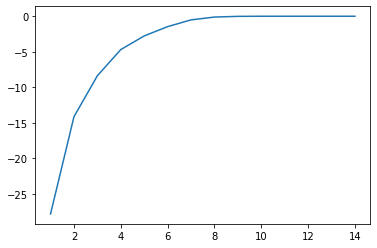

In [35]:
# Finding the elbow point

fig, ax = plt.subplots()
ax.plot(cluster_check_range, scores[1:])
plt.show()

In [45]:
# Selecting appropriate k. Here we chose k = 8

k = 5
cluster_model = kmeans[k]

df_grouped['cluster'] = cluster_model.predict(data_scaled)
df_grouped['cluster'].value_counts()
df = df_grouped['cluster'].value_counts().rename_axis('Cluster number').reset_index(name='counts')
df

,Cluster number,counts
0,1,22
1,0,1
2,2,1


In [37]:
# final_data - df_grouped
# data_new - data_scaled

[t-SNE] Computing 23 nearest neighbors...
[t-SNE] Indexed 24 samples in 0.000s...
[t-SNE] Computed neighbors for 24 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 24 / 24
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.374916
[t-SNE] KL divergence after 300 iterations: 0.512039


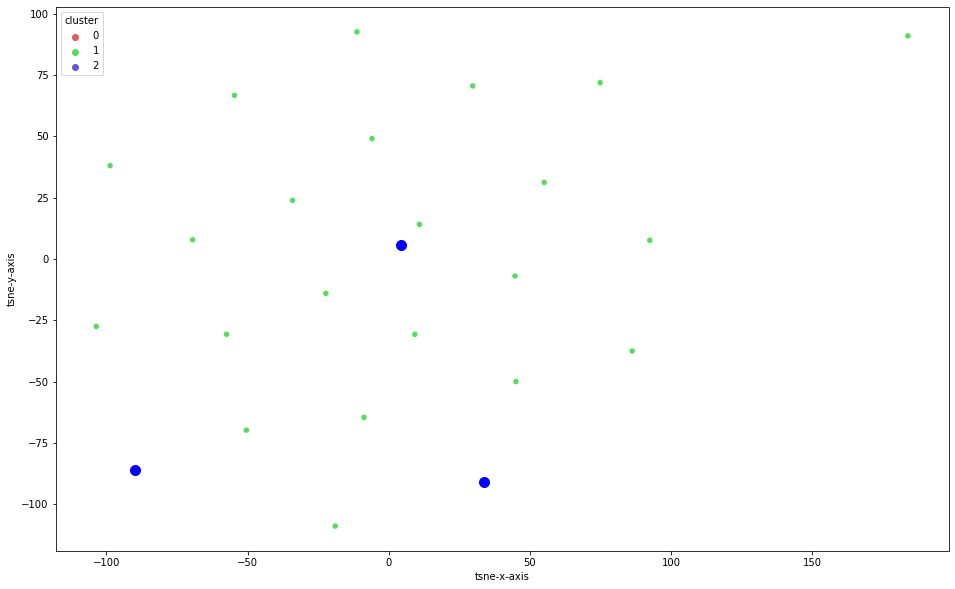

In [46]:
# Applying tSNE to visualise data in 2D

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=RANDOM_STATE)
tsne_results = tsne.fit_transform(data_scaled)

df_grouped['tsne-x-axis'] = tsne_results[:,0]
df_grouped['tsne-y-axis'] = tsne_results[:,1]
df_grouped

tsne_cluster = df_grouped.groupby('cluster').agg({'tsne-x-axis':'mean', 'tsne-y-axis':'mean'}).reset_index()

plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-x-axis", y="tsne-y-axis",
    hue="cluster",
    palette=sns.color_palette("hls", k),
    data=df_grouped,
    legend="full",
    alpha=1
)

plt.scatter(x="tsne-x-axis", y="tsne-y-axis", data=tsne_cluster, s=100, c='b')
plt.show()

/var/folders/vc/7h0bt82n7g916rsm87krcvc00000gn/T/ipykernel_75787/1709323777.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  total_distance = pd.Series()


(array([ 2.,  0.,  0.,  0.,  0., 16.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([20.18200206, 20.30665885, 20.43131564, 20.55597244, 20.68062923,
        20.80528602, 20.92994282, 21.05459961, 21.1792564 , 21.3039132 ,
        21.42856999, 21.55322678, 21.67788358, 21.80254037, 21.92719716,
        22.05185396, 22.17651075, 22.30116754, 22.42582434, 22.55048113,
        22.67513792, 22.79979472, 22.92445151, 23.0491083 , 23.1737651 ,
        23.29842189, 23.42307868, 23.54773548, 23.67239227, 23.797049

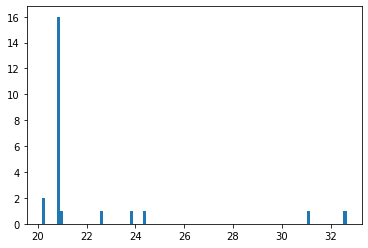

In [47]:
# Plotting histogram of sum_squared_distances of all points from the center of clusters

def get_ssd(data, cluster_model, feature_cols):
    centers = cluster_model.cluster_centers_
    points = np.asarray(data[feature_cols])
    total_distance = pd.Series()
    for i in range(len(points)):
        total_distance.at[i] = get_distance(centers, points, i)
    return total_distance  

def get_distance(centers, points, i):
    distance = 0
    for j in range(len(centers)):
        d = np.linalg.norm(points[i] - centers[j])
        distance += d**2
    return distance


centers = cluster_model.cluster_centers_
points = np.asarray(data_scaled)

df_grouped['ssd'] = get_ssd(data_scaled, cluster_model, feature_cols)

plt.hist(df_grouped['ssd'], bins=100)

<AxesSubplot:xlabel='tsne-x-axis', ylabel='tsne-y-axis'>

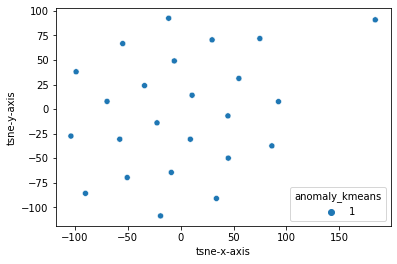

In [48]:
# Setting cutoff to ssd for anomaly

cutoff = 15
df_grouped['anomaly_kmeans'] = (df_grouped['ssd'] >= cutoff).astype(int)

sns.scatterplot(
    x="tsne-x-axis", y="tsne-y-axis",
    hue="anomaly_kmeans",
    data=df_grouped,
    legend="full",
    alpha=1
)


In [49]:
# Listing anomalous rows according to k-means

df_grouped.loc[df_grouped['anomaly_kmeans']==1]

,Date,total_msgs,WARN_count,INFO_count,DEBUG_count,TRACE_count,ERROR_count,FATAL_count,b2c05d68_count,0d0355b4_count,...,c4a0945f_count,a1404f2b_count,3f7fe44b_count,7e78fdb9_count,cluster,tsne-x-axis,tsne-y-axis,ssd,anomaly_kmeans,anomaly_isolated
0,2023-03-29 01:25:00,26,0,26,0,0,0,0,1,1,...,0,0,0,0,0,33.828384,-91.037262,32.647681,1,1
1,2023-03-29 01:30:00,62,0,62,0,0,0,0,0,0,...,3,1,1,0,2,-89.871292,-85.826324,24.331808,1,0
2,2023-03-29 01:35:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,92.447174,7.613305,20.911403,1,0
3,2023-03-29 01:40:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,183.884674,90.919693,20.911403,1,0
4,2023-03-29 01:45:00,24,0,24,0,0,0,0,0,0,...,0,1,1,0,1,10.858780,14.107049,22.660688,1,0
5,2023-03-29 01:50:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,44.709888,-6.916963,20.911403,1,0
6,2023-03-29 01:55:00,404,0,404,0,0,0,0,0,0,...,0,0,0,0,1,29.751833,70.518456,31.033366,1,0
7,2023-03-29 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,45.047913,-49.940418,20.911403,1,0
8,2023-03-29 02:05:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-18.961596,-108.803719,20.911403,1,0
9,2023-03-29 02:10:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,74.860313,71.859192,20.911403,1,0


,Date,total_msgs,WARN_count,INFO_count,DEBUG_count,TRACE_count,ERROR_count,FATAL_count,b2c05d68_count,0d0355b4_count,...,c4a0945f_count,a1404f2b_count,3f7fe44b_count,7e78fdb9_count,cluster,tsne-x-axis,tsne-y-axis,ssd,anomaly_kmeans,anomaly_isolated
0,2023-03-29 01:25:00,26,0,26,0,0,0,0,1,1,...,0,0,0,0,0,33.828384,-91.037262,32.647681,1,1


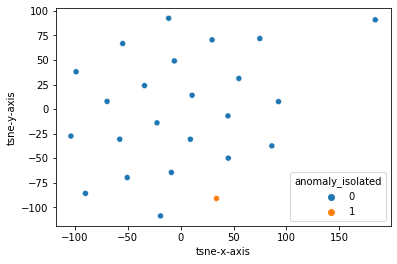

In [50]:
# Clustering using Isolated forests

from sklearn.ensemble import IsolationForest

outlier_fraction = 0.006

model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=RANDOM_STATE, contamination=outlier_fraction)
model.fit(data_scaled)

df_grouped['anomaly_isolated'] = pd.Series(model.predict(data_scaled))
df_grouped['anomaly_isolated'] = df_grouped['anomaly_isolated'].map( {1: 0, -1: 1} )

sns.scatterplot(
    x="tsne-x-axis", y="tsne-y-axis",
    hue="anomaly_isolated",
    data=df_grouped,
    legend="full",
    alpha=1
)

df_grouped.loc[df_grouped['anomaly_isolated']==1]

In [20]:
#Performance comparision

# to be done after testing the model on actual application logs